In [ ]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from imutils import paths
import os
import cv2
import datetime
import numpy as np

# Data Preprocess

In [ ]:
# load train and test dataset
def load_dataset(base_dir):
	# load dataset
  print("\n[INFO] loading images...")
  imagePaths = list(paths.list_images(base_dir))

  labels = []
  images = []

  for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    if image is None:
      continue
    
    label = imagePath.split(os.path.sep)[-2]

    image = cv2.resize(image, image_shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    images.append(image)
    labels.append(label)
  
  images = np.array(images)
  labels = np.array(labels)

  trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2)
  
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], image_size, image_size, 3))
  testX = testX.reshape((testX.shape[0], image_size, image_size, 3))
  print('data training', str(trainX.shape[0]))
  print('data testing', str(testX.shape[0]))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# Model

In [ ]:
# define cnn model with MobileNetV2
def define_model():
  base_model = MobileNetV2(input_shape=(image_size,image_size,3), 
                           include_top=False)
  # freeze the base layer
  for layer in base_model.layers:
    layer.trainable = False
  
  last_output = base_model.output
  x = GlobalAveragePooling2D()(last_output)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(5, activation='softmax')(x)

  model = Model(base_model.input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  return model

# Training

In [ ]:
def train_model(checkpoint_path):
  # use checkpoint to save best model
  checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',
                               save_best_only=True,
                               mode='auto', verbose=1)
  # define the model
  model = define_model()

  # training the head of the network
  print("[INFO] training head...")
  start = datetime.datetime.now()
  history = model.fit(trainX, trainY,
                      validation_data=(testX, testY),
                      epochs=10,
                      verbose=1,
                      callbacks=[checkpoint])
  end = datetime.datetime.now()
  elapsed = end - start
  # model.save(checkpoint_path)
  print ('Time:', elapsed)

  return model, history

def plot_training(history):
  # training plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epoch_range = range(len(acc))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, acc, label='Training Accuracy')
  plt.plot(epoch_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_range, loss, label='Training Loss')
  plt.plot(epoch_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Testing

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  #Add Normalization Option
  '''prints pretty confusion metric with normalization option'''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  # print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 

def testing():
  # make predictions on the testing set
  print("[INFO] evaluating network...")
  (test_loss, test_accuracy) = model.evaluate( 
      testX, testY, verbose=1)
  print("[INFO] Test Accuracy: {:.2f}%".format(test_accuracy * 100)) 
  print("[INFO] Test Loss: {:.4f}".format(test_loss), end='\n\n') 


  # predict testing data
  predIdxs = model.predict(testX)
  predIdxs = np.argmax(predIdxs, axis=1)

  # convert y
  testY_categorical = [np.where(r==1)[0][0] for r in testY]
  classes = list(class_labels.values())
  # show a nicely formatted classification report
  print(classification_report(testY_categorical, predIdxs,
  target_names=classes))

  # compute the confusion matrix and and use it to derive the raw
  # accuracy, sensitivity, and specificity
  cm = confusion_matrix(testY_categorical, predIdxs)
  total = len(testY_categorical)

  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm, end="\n\n")

  # show confusion matrix
  plot_confusion_matrix(cm, classes, normalize=True)

# Predict

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict(show=False):
  upload = files.upload()
  
  for fn in upload.keys():
    # predict image
    path = fn
    img = cv2.imread(path)
    img = cv2.resize(img, image_shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if show == True:
      plt.figure()
      plt.imshow(img) 
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    img_tensor = np.vstack([img_tensor])

    classes = model.predict(img_tensor)
    pred = np.argmax(classes, axis=1)

    print(class_labels[pred], np.max(classes))

# Main

In [ ]:
class_labels = {0: 'batik priangan',
                1: 'batik megamendung',
                2: 'batik pring sedapur',
                3: 'batik kawung',
                4: 'batik parang'}

image_shape = (224, 224)
image_size = 224

# load dataset
trainX, trainY, testX, testY = load_dataset("# dataset direktory")
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)


[INFO] loading images...
data training 781
data testing 196


In [ ]:
model, history = train_model("# direktory to save model.h5")

9412608/9406464 [==============================] - 0s 0us/step
[INFO] training head...
Epoch 1/10
25/25 [==============================] - 34s 102ms/step - loss: 0.9851 - accuracy: 0.6415 - val_loss: 0.4553 - val_accuracy: 0.8929

Epoch 00001: val_loss improved from inf to 0.45533, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 2/10
25/25 [==============================] - 1s 55ms/step - loss: 0.3583 - accuracy: 0.8886 - val_loss: 0.3097 - val_accuracy: 0.9082

Epoch 00002: val_loss improved from 0.45533 to 0.30974, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 3/10
25/25 [==============================] - 1s 55ms/step - loss: 0.2338 - accuracy: 0.9296 - val_loss: 0.2327 - val_accuracy: 0.9439

Epoch 00003: val_loss improved from 0.30974 to 0.23271, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 4/10
25/25 [==============================] - 1s 56ms/step - loss: 0.1616 - accuracy: 0.9539 - val_loss: 0.2053 - val_accuracy: 0.9490

Epoch 00004: val_loss improved from 0.23271 to 0.20527, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 5/10
25/25 [==============================] - 1s 57ms/step - loss: 0.1185 - accuracy: 0.9770 - val_loss: 0.1984 - val_accuracy: 0.9337

Epoch 00005: val_loss improved from 0.20527 to 0.19836, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 6/10
25/25 [==============================] - 1s 54ms/step - loss: 0.0968 - accuracy: 0.9757 - val_loss: 0.1914 - val_accuracy: 0.9388

Epoch 00006: val_loss improved from 0.19836 to 0.19142, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 7/10
25/25 [==============================] - 1s 57ms/step - loss: 0.0743 - accuracy: 0.9808 - val_loss: 0.1647 - val_accuracy: 0.9643

Epoch 00007: val_loss improved from 0.19142 to 0.16466, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 8/10
25/25 [==============================] - 1s 56ms/step - loss: 0.0575 - accuracy: 0.9923 - val_loss: 0.1647 - val_accuracy: 0.9592

Epoch 00008: val_loss did not improve from 0.16466
Epoch 9/10
25/25 [==============================] - 1s 54ms/step - loss: 0.0464 - accuracy: 0.9936 - val_loss: 0.1653 - val_accuracy: 0.9592

Epoch 00009: val_loss did not improve from 0.16466
Epoch 10/10
25/25 [==============================] - 1s 53ms/step - loss: 0.0338 - accuracy: 0.9987 - val_loss: 0.1594 - val_accuracy: 0.9643

Epoch 00010: val_loss improved from 0.16466 to 0.15936, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Time: 0:03:24.333349


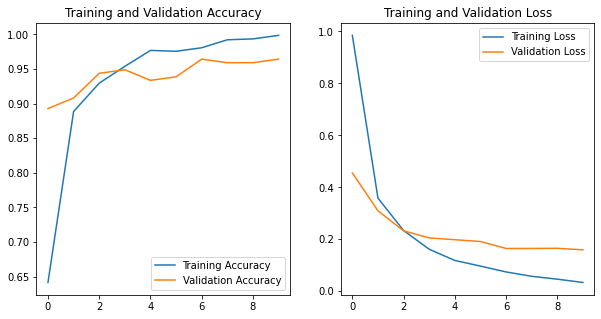

In [ ]:
# plot training accuracy and loss
plot_training(history)

[INFO] evaluating network...
7/7 [==============================] - 0s 42ms/step - loss: 0.1594 - accuracy: 0.9643
[INFO] Test Accuracy: 96.43%
[INFO] Test Loss: 0.1594

                     precision    recall  f1-score   support

     batik priangan       0.94      0.97      0.95        30
  batik megamendung       0.97      1.00      0.99        35
batik pring sedapur       0.98      0.98      0.98        45
       batik kawung       0.95      0.90      0.93        42
       batik parang       0.98      0.98      0.98        44

           accuracy                           0.96       196
          macro avg       0.96      0.97      0.96       196
       weighted avg       0.96      0.96      0.96       196

[[29  0  0  1  0]
 [ 0 35  0  0  0]
 [ 0  0 44  1  0]
 [ 1  1  1 38  1]
 [ 1  0  0  0 43]]

Normalized confusion matrix


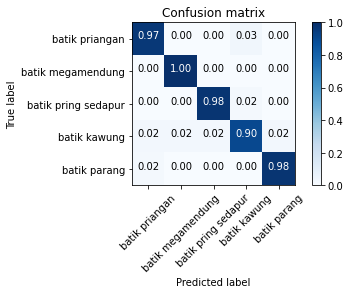

In [ ]:
# test the model
testing()

Saving download (2).jpg to download (2).jpg
Saving download (8).jpg to download (8).jpg
Saving images (10).jpg to images (10).jpg
batik megamendung 0.99960834
batik megamendung 0.997494
batik megamendung 0.99176204


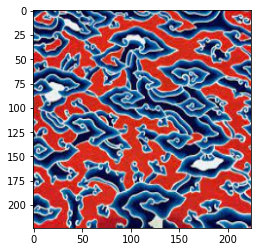

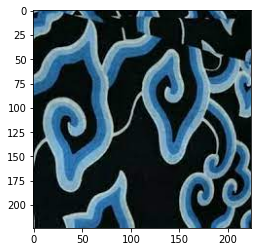

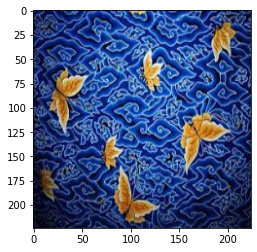

In [ ]:
# predict megamendung pattern
predict(show=True)

Saving download.jpg to download.jpg
Saving images - 2021-05-18T192012.480.jpg to images - 2021-05-18T192012.480.jpg
Saving images - 2021-05-18T192015.328.jpg to images - 2021-05-18T192015.328.jpg
batik kawung 0.99922
batik kawung 0.9999101
batik kawung 0.99659806


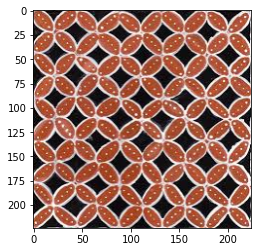

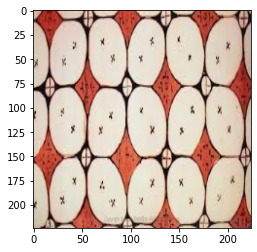

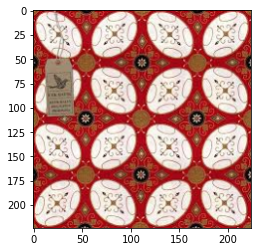

In [ ]:
# predict kawung pattern
predict(show=True)

Saving images - 2021-05-26T163630.860.jpg to images - 2021-05-26T163630.860.jpg
Saving images - 2021-05-26T163628.311.jpg to images - 2021-05-26T163628.311.jpg
Saving images - 2021-05-26T163622.942.jpg to images - 2021-05-26T163622.942.jpg
batik parang 0.99811804
batik parang 0.99081707
batik parang 0.99950874


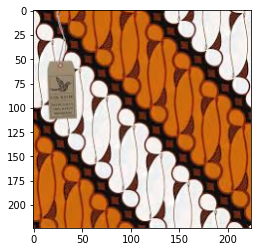

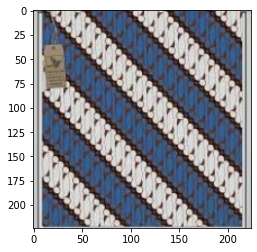

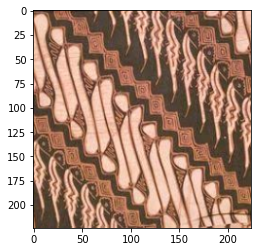

In [ ]:
# predict parang pattern
predict(show=True)

Saving download (14).jpg to download (14).jpg
Saving images - 2021-05-18T195709.464.jpg to images - 2021-05-18T195709.464.jpg
Saving images - 2021-05-18T195710.301.jpg to images - 2021-05-18T195710.301.jpg
batik pring sedapur 0.9917733
batik pring sedapur 0.9927821
batik pring sedapur 0.99021965


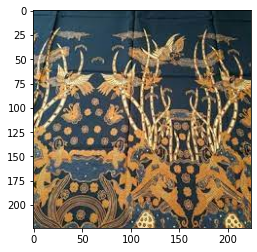

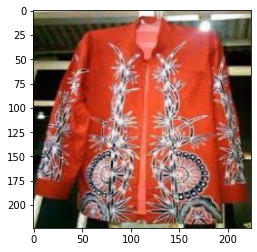

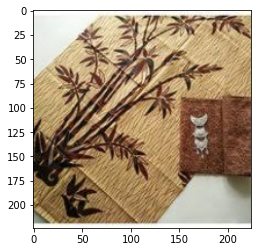

In [ ]:
# predict pring sedapur pattern
predict(show=True)

Saving download (1).jpg to download (1).jpg
Saving images (12).jpg to images (12).jpg
Saving images (37).jpg to images (37).jpg
batik priangan 0.99747247
batik priangan 0.9981084
batik priangan 0.9959407


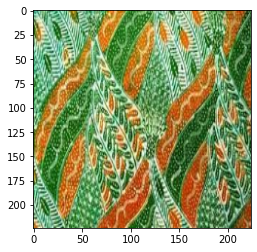

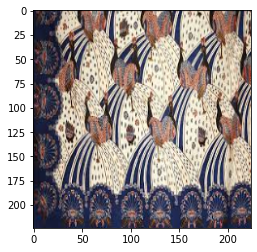

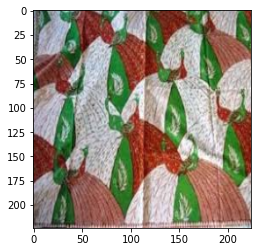

In [ ]:
# predict priangan pattern
predict(show=True)